In [1]:
import os

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Notebook for summarising total DIN and TotN inputs to the Oslofjord under different scenarios

Starting from the model input files, calculate total fluxes of DIN and TotalN to the Oslofjord from three sources:
1. River inputs
2. Direct WWTW inputs that are added to river inputs in a post-processing step by Phil
3. Direct WWTW inputs sthat are added directly to the fjord

1 & 2 are combined in a single river input netcdf file, 3 is in a separate 'internal source' netcdf file. Here, we take these netcdf model input files as starting point, then calculate monthly and annual fluxes per model river, real river and vassdragsområde and sum up over vassdragsområder. Do this for baseline and scenarios, to summarise the effect of different load reduction scenarios on total loads to the Oslofjord and to the vassdragsområder that make up the Oslofjord drainage basin.

# User input

In [2]:
# Version of processing (for file naming & reading correct inputs)
# v1: only included real rivers up to real river 20. Used in first draft of report
# v2: include all real rivers in of800 domain
version = 2

# Model river numbers to include
# v2: River input scenario generated for model rivs 7-29 (incl.), but summarise over
# the full OF800 domain (model rivers 5 to 29, inclusive, i.e. include Sweden)
oslofjord_model_riv_nos = list(range(5, 30))  # Model river numbers

# Time period to summarise over
start_year = 2013
end_year = 2022

out_folder_csvs = f"../output/csvs/v{version}"
out_folder_scenario_figs = f"../output/plots/v{version}"
out_folder_baseline_figs = f"../output/plots/baseline"

# Read in mappings

In [3]:
# Mapping from model river number to real river number (index: model riv no, returns real no)
setup_fpath = r"../data/oslofjord_location_ids.csv"
river_nos_s = pd.read_csv(setup_fpath, index_col=0).squeeze('columns')
river_nos_s.head()

model_river
1    1
2    1
3    2
4    3
5    4
Name: real_river, dtype: int64

In [4]:
# Mapping real river to vassdragsområde

# Work out corresponding real river numbers
min_val = min(oslofjord_model_riv_nos)
max_val = max(oslofjord_model_riv_nos)
oslofjord_real_riv_nos = river_nos_s.loc[min_val:max_val].tolist()
# Drop non-unique
oslofjord_real_riv_nos = list(set(oslofjord_real_riv_nos))
print(oslofjord_real_riv_nos)

real_riv_metadata = r"../data/real_river_metadata.csv"
river_meta_df = pd.read_csv(real_riv_metadata, index_col=0, dtype={'Vassom':str})

# Limit to just Oslofjord rivers
river_meta_df = river_meta_df[river_meta_df.index.isin(oslofjord_real_riv_nos)]

# Fill NaNs in the Vassdragsområde columns with 'Sweden'
river_meta_df.loc[river_meta_df.index < 6, 'Vassom'] = river_meta_df.loc[river_meta_df.index < 6, 'Vassom'].fillna('Sweden')

river_meta_df['Vassom_name'] = river_meta_df.apply(lambda row: 'Sweden' if row['Vassom'] == 'Sweden' else row['river_name'], axis=1)

river_meta_df

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23]


,river_name,Outflow_lat,Outflow_lon,Regine,Regine_to_sea,Vassom,Vassom_area_land,Vassom_area_tot,Andre_MCA_area,Andre_area_q,Overestimate (%),Comment,Vassom_name
real_river,,,,,,,,,,,,,
4,Strömsån,NaN,NaN,NaN,NaN,Strömsån,467.0,NaN,NaN,NaN,NaN,NaN,Strömsån
5,Enningdalsälv,NaN,NaN,NaN,NaN,Enningdalsälv,810.0,NaN,NaN,NaN,NaN,NaN,Enningdalsälv
6,Tista,59.119,11.370,001.A1,001.A1,001.,2495.0,2507.0,2507.0,1584.0,0.0,NaN,Tista
7,Glomma,59.206,10.953,002.A51,002.A11,002.,42446.0,43116.0,43116.0,41967.0,2.0,Monitoring point upstream of Sarpsborg RA. So ...,Glomma
8,Mosseelva,59.439,10.662,003.A1,003.A1,003.,854.0,1052.0,1054.0,694.0,23.0,NaN,Mosseelva
9,Hølenelva,59.523,10.690,004.A0,004.A0,004.,204.0,227.0,NaN,NaN,11.0,NaN,Hølenelva
10,Årungen,59.720,10.728,005.3A,005.3A,005.,280.0,368.0,144.0,85.0,31.0,NaN,Årungen
11,Akerselva,59.908,10.756,006.A10,006.A10,006.,392.0,415.0,415.0,307.0,6.0,NaN,Akerselva
12,Lysakerelva,59.914,10.640,007.A0,007.A0,007.,202.0,211.0,211.0,177.0,4.0,NaN,Lysakerelva


In [5]:
# Mapping vassdragsområde number to area
vass_areas_s = river_meta_df[['Vassom', 'Vassom_area_land']].copy()
vass_areas_s.set_index('Vassom', inplace=True)
vass_areas_s.drop_duplicates(inplace=True)
vass_areas_s = vass_areas_s.squeeze()

In [6]:
# Make mapping from Vassdragsområde number to name
vass_num_to_name = river_meta_df[['Vassom', 'Vassom_name']].copy()
vass_num_to_name.set_index('Vassom', inplace=True)
vass_num_to_name.drop_duplicates(inplace=True)
vass_num_to_name = vass_num_to_name.squeeze()

In [7]:
# Mapping from real river number to river name
river_names_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_names.csv'
river_names_s = pd.read_csv(river_names_fpath, index_col=0).squeeze('columns')
river_names_s.head()

real_river
1         Göta älv
2           Bäveån
3     Örekilsälven
4         Strömsån
5    Enningdalsälv
Name: river_name, dtype: object

In [8]:
# Vassdragsområde to real river
nog_river_meta_df = river_meta_df[river_meta_df['Vassom'].notna()].copy()
vass_to_realriv_dict = nog_river_meta_df.reset_index().set_index('Vassom')['real_river'].to_dict()
vass_to_realriv_dict

{'Strömsån': 4,
 'Enningdalsälv': 5,
 '001.': 6,
 '002.': 7,
 '003.': 8,
 '004.': 9,
 '005.': 10,
 '006.': 11,
 '007.': 12,
 '008.': 13,
 '009.': 14,
 '010.': 15,
 '011.': 17,
 '012.': 18,
 '013.': 19,
 '014.': 20,
 '015.': 21,
 '016.': 22,
 '017.': 23}

In [9]:
wwtp_isource_map_fpath = r'../data/Flux_Martini_Rivers_sewage_with_mapping_and_fractions_v2.xlsx'
isource_vassom_map_df = pd.read_excel(wwtp_isource_map_fpath, sheet_name='vassområde_link', index_col=0)
# Reformat vassdragsområde integer to match string format used elsewhere
isource_vassom_map_df['Vassdragsområde'] = isource_vassom_map_df['Vassdragsområde'].apply(lambda x: (str(x)).zfill(3) + '.')
isource_vassom_map_df

,Vassdragsområde,Comment
iSource,,
1,003.,NaN
2,003.,NaN
3,003.,NaN
4,004.,NaN
5,005.,NaN
6,006.,NaN
7,009.,VEAS main outlet
8,011.,NaN
9,012.,NaN


# Read in and process river netcdf files

## Define functions

In [10]:
def riv_ds_to_df(nc_fpath, oslofjord_model_riv_nos):
    """
    Read in OF800 river input netcdf file. Convert to dataframe of concentrations
    & river discharge for real rivers.
    N.B. Only works for N species, has some hard-coding
    """

    riv_var_li = ["river_transport", "river_N3_n", "river_N4_n",
                  "river_R123_n", "river_R4_n", "river_R6_n", "river_R8_n"]
    riv_chem_var_li = [item for item in riv_var_li if item != 'river_transport']

    ds = xr.open_dataset(nc_fpath)
    ds = ds[riv_var_li]
    df = ds.to_dataframe()
    ds.close()
    df = df.reset_index()  # Drop multiindex

    # Remove depth info
    if 's_rho' in df.columns:
        df = df.drop(columns=['s_rho'])
        df = df.drop_duplicates()  # There were around 40 s_rho values for each (river_time, river)

    df = df.sort_values(by=['river', 'river_time'])

    # Take the absolute of discharge values (assume they give direction)
    df['river_transport'] = df['river_transport'].abs()

    df = df.reset_index(drop=True)

    # Select just model river numbers of interest
    df = df[df['river'].isin(oslofjord_model_riv_nos)]

    # Add real river number & drop the model number
    df['river_no'] = df['river'].map(river_nos_s)
    df = df.drop(columns=['river'])

    # Truncate to time period of interest
    df['year'] = df['river_time'].dt.year
    df = df.loc[(df['year'] >= start_year) & (df['year'] <= end_year)]
    df = df.drop('year', axis=1)

    # Calculate Total N & DIN, and drop the other N fractions
    df['TOTN'] = df[riv_chem_var_li].sum(axis=1)
    df['DIN'] = df['river_N3_n'] + df['river_N4_n']
    # N.B. ignoring the 1% of TPN that Phil adds as PIN
    # Drop all the fractions apart from TOTN and DIN 
    df = df.drop(riv_chem_var_li, axis=1)

    # Sum over model rivers to get real river data

    # Check if all discharge values in each group are the same. If not, will have to
    # flow-weight the concentrations when calculating means
    # is_constant = df.groupby(['river_no', 'river_time'])['river_transport'].nunique() <= 1
    # if not is_constant.all():
    #     print(f"Discharge values are not the same for all real river model groupings")
    # else:
    #     print("Discharge values constant between model river groups")

    grouped = df.groupby(['river_no', 'river_time'])
    is_constant = grouped['river_transport'].nunique() <= 1
    if not is_constant.all():
        print(f"Discharge values are not the same for all real river model groupings")
        # Find the first group where river_transport is not constant
        non_constant_groups = is_constant[is_constant == False]
        first_non_constant_group = non_constant_groups.index[0]
        last_non_constant_group = non_constant_groups.index[-1]
        # Print out the values of the first group where river_transport is not constant
        print("Values of the first & last groups where river_transport is not constant:")
        print(grouped.get_group(first_non_constant_group))
        print(grouped.get_group(last_non_constant_group))
        print("Number of non-constant groups: %s" % len(non_constant_groups))
    else:
        print("Discharge values constant between model river groups")

    # For QC. Manually checked the summing & averaging working ok. It is.
    # print(df.loc[(df['river_no'] == 7) & (df['river_time'] == '2016-01-01 12:00')])

    # Sum discharge
    conc_df = df.groupby(['river_no', 'river_time']).agg({'river_transport': 'sum'})

    # Mean of all other columns within each river
    mean_df = df.groupby(['river_no', 'river_time'])[['TOTN', 'DIN']].mean()

    # Join the sums and means to one df
    conc_df = pd.concat([conc_df, mean_df], axis=1)
    conc_df = conc_df.reset_index()

    # Convert concentration units from mMoles/m3 to mg/l
    # N.B. HARDCODED, needs generalising for diff vars & units
    Mr_N = 14.0067
    for col in ['TOTN', 'DIN']:
        conc_df[col] = conc_df[col] * Mr_N * 0.001

    # Rename cols
    # Warning: HARDCODED, needs generalising for diff vars
    new_col_names = ['real_river', 'date', 'Q', 'TOTN', 'DIN']
    conc_df = conc_df.set_axis(new_col_names, axis=1)

    return conc_df


def calc_daily_flux(conc_df, out_folder, run_type):
    """ Units kg/day
    """
    load_df = conc_df[['real_river', 'date']].copy()
    # Ensure the 'date' column is in datetime format
    load_df['date'] = pd.to_datetime(load_df['date'])
    load_df['Q'] = conc_df['Q'] * 86400  # from m3/s to m3/day

    for var in ['TOTN', 'DIN']:
        # Load in kg/day
        chem_kgperm3 = conc_df[var] * 1000 * 10**-6
        load_df[var] = load_df['Q'] * chem_kgperm3

    # To csv
    fpath = os.path.join(out_folder, f'daily_river_fluxes_{start_year}-{end_year}_{run_type}.csv')
    load_df.to_csv(fpath)

    return load_df


def calc_month_annual_flux(daily_load_df, freq, out_folder, run_type):
    """
    Input:
        freq: 'monthly' for monthly, 'annual' for annual
        run_type: string, for file naming. E.g. 'baseline'
    Output: df, units Q: 10^6 m3/month or year; N: T/month or year
    """
    freq_dict = {'monthly': 'ME',
                 'annual': 'YE'}

    # daily_load_df.set_index(['real_river', 'date'], inplace=True)
    agg_load_df = daily_load_df.set_index(['real_river', 'date']).groupby('real_river').resample(freq_dict[freq], level='date').sum()
    agg_load_df.reset_index(inplace=True)

    # Convert units: N species from kg to 10^3 kg/month (T/month)
    for var in ['TOTN', 'DIN']:
        agg_load_df[var] = agg_load_df[var] / 10**3

    # Convert Q from m3/month to 10^6 m3/month
    agg_load_df['Q'] = agg_load_df['Q'] / 10**6

    if freq == 'annual':
        agg_load_df['year'] = pd.to_datetime(agg_load_df['date']).dt.year
        agg_load_df = agg_load_df.drop('date', axis=1)

    # Write to csv
    fpath = os.path.join(out_folder, f'{freq}_river_fluxes_{start_year}-{end_year}_{run_type}.csv')
    agg_load_df.to_csv(fpath)

    return agg_load_df


def mean_annual_flux(annual_load_df, out_folder, run_type):
    """
    Average over years to get overall mean annual flux per real river
    Inputs run_type: format string, for filenaming
    Output: df, index: real_river, cols: Q (10^6 m3/yr), TOTN and DIN (T/yr)
    """
    yr_mean_df = annual_load_df[['Q', 'TOTN', 'DIN', 'real_river']].groupby('real_river').mean()

    # Write to csv
    fpath = os.path.join(out_folder, f'mean_annual_riv_flux_{start_year}-{end_year}_{run_type}.csv')
    yr_mean_df.to_csv(fpath)

    return yr_mean_df

## Processing

In [11]:
# Setup
nc_folder = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/of800_input_files/'
flux_folder = r'../output/csvs/of800_fluxes'

nc_fname_dict = {'baseline': 'of800_rivers_v9_1990_2022_RA1_baseline.nc',
                 'remove_summer_din': 'of800_rivers_v9_1990_2022_RA1_SummerDINsources100pcred.nc',
                 'realistic': f'of800_rivers_v9_2013_2022_RA1_DINredRA80-J10_v{version}.nc'
                }

In [12]:
# Testing with just one scenario
nc_fpath = os.path.join(nc_folder, nc_fname_dict['baseline'])
conc_df = riv_ds_to_df(nc_fpath, oslofjord_model_riv_nos)

Discharge values are not the same for all real river model groupings
Values of the first & last groups where river_transport is not constant:
                river_time  river_transport  river_no        TOTN         DIN
249461 2013-01-01 12:00:00         4.092533        20  195.167572  150.303589
261514 2013-01-01 12:00:00         9.549243        20  195.167572  150.303589
                river_time  river_transport  river_no        TOTN         DIN
253112 2022-12-31 12:00:00        11.716590        20  153.012207  136.824402
265165 2022-12-31 12:00:00        27.338709        20  153.012207  136.824402
Number of non-constant groups: 3652


**Comment:** Real river 20 (Aulielva) is split into two model rivers. The two model rivers have different discharge but the same TOTN and DIN concentrations. So it is ok to calculate the mean discharge of the real river group without weighting by discharge, as the mean is the same as the individual model river values anyway. 2557 non-constant groups is equivalent to 7 years of data * 365 days per year. i.e. it's only river 20 this applies to. For all other real rivers that are split into multiple model rivers, the discharge is split evenly between model rivers.

In [13]:
# Process for all scenarios

daily_conc_dict = {}
monthly_rivflux_dict = {}
annual_rivflux_dict = {}
mean_annual_rivflux_dict = {}

for scenario in nc_fname_dict.keys():

    print(scenario)

    nc_fpath = os.path.join(nc_folder, nc_fname_dict[scenario])
    conc_df = riv_ds_to_df(nc_fpath, oslofjord_model_riv_nos)

    daily_load_df = calc_daily_flux(conc_df, flux_folder, scenario)
    monthly_load_df = calc_month_annual_flux(daily_load_df, 'monthly', flux_folder, scenario)
    annual_load_df = calc_month_annual_flux(daily_load_df, 'annual', flux_folder, scenario)
    mean_annual_load_df = mean_annual_flux(annual_load_df, flux_folder, scenario)

    # Add to dictionaries
    daily_conc_dict[scenario] = conc_df
    monthly_rivflux_dict[scenario] = monthly_load_df
    annual_rivflux_dict[scenario] = annual_load_df
    mean_annual_rivflux_dict[scenario] = mean_annual_load_df

    print(annual_load_df.head())
    print(mean_annual_load_df)
    print('\n')

baseline
Discharge values are not the same for all real river model groupings
Values of the first & last groups where river_transport is not constant:
                river_time  river_transport  river_no        TOTN         DIN
249461 2013-01-01 12:00:00         4.092533        20  195.167572  150.303589
261514 2013-01-01 12:00:00         9.549243        20  195.167572  150.303589
                river_time  river_transport  river_no        TOTN         DIN
253112 2022-12-31 12:00:00        11.716590        20  153.012207  136.824402
265165 2022-12-31 12:00:00        27.338709        20  153.012207  136.824402
Number of non-constant groups: 3652
   real_river          Q       TOTN        DIN  year
0           4  30.316006  23.592158   7.297247  2013
1           4  44.848849  35.354236  11.056890  2014
2           4  39.219846  32.348984  12.086646  2015
3           4  18.174750  15.763338   7.265982  2016
4           4  27.655560  27.664767  11.040932  2017
                       Q   

# Read in direct sewage inputs

Calculate the total wastewater treatment plant N loads that are included in OF800 as direct inputs to the fjord. This is implemented either by adding loads to the model river fluxes (PWA does this as a post-processing step) or adding loads directly to the fjord (the iSources netcdf file).

In [14]:
def isource_to_df(wwtp_fpath):
    """
    Input: filepath to ERSEM internal sources netcdf
    Output: Dataframe of monthly fluxes (units T/month)
    Read in ERSEM internal source netcdf.
    Only keep N data, convert units to mg/l, drop depth info,
    calculate total N and DIN, save as dataframe
    """

    # Molecular weight of N (g/mole)
    Mr_N = 14.0067

    # WWTP direct inputs
    wwtp_ds = xr.open_dataset(wwtp_fpath)

    # Sum over the 's_rho' dimension
    wwtp_ds = wwtp_ds.sum(dim='s_rho')

    wwtp_df = wwtp_ds.to_dataframe()
    wwtp_df = wwtp_df.reset_index()  # Drop multiindex
    wwtp_ds.close()

    # Drop all WWTPs which are outside oslofjord
    # wwtp_df = wwtp_df[wwtp_df['isource'].isin(isource_oslofjord_ids)]

    # Rename date column & truncate to time period of interest
    wwtp_df['isource_time'] = pd.to_datetime(wwtp_df['isource_time'])
    wwtp_df = wwtp_df.rename(columns={'isource_time': 'date'})
    wwtp_df['year'] = wwtp_df['date'].dt.year
    wwtp_df = wwtp_df.loc[(wwtp_df['year'] >= start_year) & (wwtp_df['year'] <= end_year)]
    wwtp_df = wwtp_df.drop('year', axis=1)

    print('Number of WWTPs: %s ' % len(wwtp_df['isource'].drop_duplicates()))

    # Drop all columns which are not N fluxes
    cols_to_keep = ['isource', 'date'] + [col for col in wwtp_df.columns if col.endswith('_n')]
    wwtp_df = wwtp_df[cols_to_keep]

    # Calculate TOTN
    cols_to_exclude = ['isource', 'date']
    cols_to_sum = [col for col in cols_to_keep if col not in cols_to_exclude]

    # Create a new column 'sum' that is the sum of all columns in cols_to_sum
    wwtp_df['TOTN'] = wwtp_df[cols_to_sum].sum(axis=1)
    wwtp_df['DIN'] = wwtp_df['isource_N3_n'] + wwtp_df['isource_N4_n']

    wwtp_chem_vars = ['TOTN', 'DIN']

    # Drop all the subfractions apart from TOTN and DIN
    wwtp_df = wwtp_df.drop(cols_to_sum, axis=1)

    # Convert units from mmol/s to 10^3 kg/month (tonnes/month)
    # NB NEEDS IMPROVING, not accurate now, uses average number of days/month
    # instead of actual number of days/month
    for var in ['TOTN', 'DIN']:
        wwtp_df[var] = wwtp_df[var] * Mr_N * 86400 * 30.417 * 10**-9

    return wwtp_df


def calculate_average_annual_sum(monthly_df, start_year, end_year):
    """
    Input: df with columns 'isource' and 'date', plus data
    Output: Fluxes of TOTN, DIN. Units T/yr
    """
    # Pick out years within the user-specified range
    df = monthly_df.copy()
    df['year'] = df['date'].dt.year
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)].copy()

    # Calculate annual sums for all the remaining years
    df = df[['TOTN', 'DIN', 'isource', 'year']].groupby(['isource', 'year']).sum().reset_index()

    # Average the annual sums to get a single value per isource
    df = df.groupby('isource').mean()

    # Drop 'year' column
    df = df[['TOTN', 'DIN']]

    return df


def sum_over_vassom(input_df, time_col=[]):
    """
    Sum up multiple iSource inputs per vassdragsområde
    Input:
        input_df: dataframe, column or index=iSource id
        time_col: list of column names in input_df to base grouping on. E.g.
                  ['date']
    Output: dataframe, index=Vassdragsområde (format '00x.') if time_col==[], 
            otherwise, same cols as input df
            Units: T/yr
    """
    df = input_df.copy()

    # Add Vassdragsområde to the dataframe
    if 'isource' in df.columns:
        df['Vassom'] = df['isource'].map(isource_vassom_map_df['Vassdragsområde'])
    else:
        df['Vassom'] = df.index.map(isource_vassom_map_df['Vassdragsområde'])

    # Drop rows where Vassom == NaN (further SW than we are considering here)
    df = df.dropna(subset=['Vassom'])

    grouping_cols = ['Vassom'] + time_col
    df = df[grouping_cols + ['TOTN', 'DIN']].groupby(grouping_cols).sum()

    # If no time col, keep the index as Vassom. Otherwise, reset it
    if time_col != []:
        df = df.reset_index()

    return df


def read_wwtp_river_inputs(fpath, sheet):
    """
    Some of the WWTWs around Oslofjord are added to the river input file rather
    than as iSources. Read in those data here and sum them up over vassdragsområder
    Input: filepath to excel file and sheet name
    Output: dataframe, index: Vassdragsområde number (format '00x.'), fluxes in T/yr
    """
    wwtp_riv_df = pd.read_excel(fpath, sheet)
    wwtp_riv_df = wwtp_riv_df[['model_riv_id', 'TN_total_ton_yr', 'DIN_total_ton_yr']]

    # Map model river numbers to real river numbers
    wwtp_riv_df['real_riv_id'] = wwtp_riv_df['model_riv_id'].map(river_nos_s)

    # Add vassdragsområde
    wwtp_riv_df['Vassom'] = wwtp_riv_df['real_riv_id'].map(river_meta_df['Vassom'])

    # Sum up multiple inputs per Vassom
    wwtp_riv_df = wwtp_riv_df[['TN_total_ton_yr', 'DIN_total_ton_yr', 'Vassom']].groupby('Vassom').sum()

    # Match column names to isource dataframe
    wwtp_riv_df.columns = ['TOTN', 'DIN']

    return wwtp_riv_df


def total_annual_wwtw_inputs(isource_df, wwtp_riv_df, units='T'):
    """
    Sum direct WWTW inputs from the iSource file and inputs added to
    the river file to get total extra WWTW additions to Oslofjord
    Input: units can be 'T' or 'kg' per year
    """

    direct_wwtp_annual_df = wwtp_riv_df.add(isource_df, fill_value=0)

    # Also add in mapping to real_river, for compatibility with work below
    mapping_dict = river_meta_df.reset_index().set_index('Vassom')['real_river'].to_dict()
    direct_wwtp_annual_df['real_river'] = direct_wwtp_annual_df.index.map(mapping_dict)

    # Drop NaNs (Larvik in this case)
    direct_wwtp_annual_df = direct_wwtp_annual_df.dropna(how='any', axis=0)

    # Optionally convert units to kg
    if units == 'kg':
        direct_wwtp_annual_df[['TOTN', 'DIN']] = round((direct_wwtp_annual_df[['TOTN', 'DIN']] * 1000), 2)

    return direct_wwtp_annual_df

In [15]:
nc_isource_fname_dict = {'baseline': 'of800_v10b_isource_1990_2022_baseline.nc',
                         'remove_summer_din': 'of800_v10b_isource_1990_2022_SummerDINsources100pcred.nc',
                         'realistic': 'of800_v10b_isource_2013_2022_DINredRA80-J10_v1.nc'
                        }

# isource_oslofjord_ids = list(range(1, 14)) + [23]  # Just directly inputting to Oslofjord

monthly_isource_dict = {}
mean_annual_isource_dict = {}

# Process
for scenario in nc_isource_fname_dict.keys():

    print(scenario)

    nc_fpath = os.path.join(nc_folder, nc_isource_fname_dict[scenario])
    wwtp_isource_df = isource_to_df(nc_fpath)
    isource_monthly_vassom_df = sum_over_vassom(wwtp_isource_df, ['date'])  #Cols Vassom, date, TOTN, DIN
    # Only calculate average for WWTW over period when have good data for
    isource_av_yr_df = calculate_average_annual_sum(wwtp_isource_df, 2016, 2018)
    isource_av_yr_vassom_df = sum_over_vassom(isource_av_yr_df)

    # Add to dictionaries
    monthly_isource_dict[scenario] = isource_monthly_vassom_df
    mean_annual_isource_dict[scenario] = isource_av_yr_vassom_df

    print(isource_monthly_vassom_df.head())
    print(isource_av_yr_vassom_df)
    # print(wwtp_isource_df.head())
    # print(isource_av_yr_df)
    print('\n')

baseline
Number of WWTPs: 23 
  Vassom       date       TOTN        DIN
0   003. 2013-01-15  24.172932  21.726918
1   003. 2013-02-15  24.172932  21.726918
2   003. 2013-03-15  24.172932  21.726918
3   003. 2013-04-15  24.172932  21.726918
4   003. 2013-05-15  24.172932  21.726918
               TOTN          DIN
Vassom                          
003.     290.075179   260.723017
004.      56.661621    50.928138
005.      56.560620    49.157339
006.     394.914328   257.202619
007.      16.290673    12.413905
009.    1194.607017  1023.661916
011.      94.133032    84.607887
012.     294.822231   256.232628
013.     149.703841   134.555591
014.     294.040482   256.890798
015.     350.159727   314.727723
016.     301.950889   271.397047
017.       4.848053     4.213486


remove_summer_din
Number of WWTPs: 23 
  Vassom       date       TOTN        DIN
0   003. 2013-01-15  24.172932  21.726918
1   003. 2013-02-15  24.172932  21.726918
2   003. 2013-03-15  24.172932  21.726918
3   003. 2013-

# Add river and direct WWTW inputs together

## Annual

In [44]:
# Annual averages
tot_annual_av_dict = {}
tot_of_dict = {}

for scenario in nc_fname_dict.keys():
    # Get river data
    riv_vassom_df = mean_annual_rivflux_dict[scenario].copy()

    # Sum river data over Vassdragsområde & reindex
    riv_vassom_df['Vassom'] = riv_vassom_df.index.map(river_meta_df['Vassom'])
    # Drop rows where Vassom == NaN (further SW than we are considering here)
    # riv_vassom_df = riv_vassom_df.dropna(subset=['Vassom'])
    riv_vassom_df = riv_vassom_df.groupby(['Vassom']).sum()

    # Get direct WWTW input data
    wwtp_df = mean_annual_isource_dict[scenario].copy()

    # Join the data

    # Add suffixes to the columns of each dataframe
    tmp_riv_df = riv_vassom_df.copy()
    tmp_riv_df.columns = [str(col) + '_riv' for col in riv_vassom_df.columns]
    tmp_wwtp_df = wwtp_df.copy()
    tmp_wwtp_df.columns = [str(col) + '_wwtw' for col in wwtp_df.columns]

    # Concatenate
    concat_df = pd.concat([tmp_riv_df, tmp_wwtp_df], axis=1)

    # We have river scenario data up to Vassom 14, but iSource data up to
    # Vassom 15. Drop Vassom 15 (with no river data)
    # concat_df = concat_df[concat_df['TOTN_riv'].notna()]

    # Replace NaNs in the wwtw columns with 0
    concat_df = concat_df.fillna(0)

    # Sum up over whole Oslofjord to look at % input from rivs vs direct WWTWs
    tot_of_concat_s = concat_df.sum()
    # tot_of_concat_s['f_tn_wwtw'] = tot_of_concat_s['TOTN_wwtw'] / tot_of_concat_s['TOTN_riv']
    # tot_of_concat_s['f_din_wwtw'] = tot_of_concat_s['DIN_wwtw'] / tot_of_concat_s['DIN_riv']

    # Sum up river & direct WWTW inputs per vassdragsområde
    sum_df = concat_df[['Q_riv']].copy()
    sum_df.columns = ['Q']
    for var in ['TOTN', 'DIN']:
        sum_df[var] = concat_df[f'{var}_riv'] + concat_df[f'{var}_wwtw']

    tot_annual_av_dict[scenario] = sum_df

    # Sum up combined total inputs over whole Oslofjord domain
    tot_of_s = sum_df.sum()  # series, index values Q, TOTN, DIN
    tot_of_dict[scenario] = tot_of_s

tot_annual_av_dict['baseline']

,Q,TOTN,DIN
Vassom,,,
001.,1160.162718,1123.581017,680.320512
002.,22291.309158,13539.168838,9001.959166
003.,501.771946,835.245193,602.568074
004.,101.065415,349.458557,248.151199
005.,78.455633,291.179254,199.130056
006.,206.994983,477.857282,301.925607
007.,154.329399,93.810684,42.208308
008.,169.165548,134.572174,88.847243
009.,307.463644,1658.468712,1334.596947


In [45]:
# Make a dataframe of whole Oslofjord fluxes
tot_of_df = pd.DataFrame(tot_of_dict)

# Make 25, 50, 75 and 100% reduction scenarios
for pc in [25, 50, 75, 100]:
    pc_factor = 1 - (pc/100)
    tot_of_df[f'{pc}_DIN'] = tot_of_df['baseline']
    tot_of_df.loc['DIN', f'{pc}_DIN'] = tot_of_df.loc['DIN', 'baseline'] * pc_factor
    TN_reduction = tot_of_df.loc['DIN', 'baseline'] - tot_of_df.loc['DIN', f'{pc}_DIN']
    tot_of_df.loc['TOTN', f'{pc}_DIN'] = tot_of_df.loc['TOTN', 'baseline'] - TN_reduction

tot_of_df = tot_of_df.round(1).transpose()
fpath = os.path.join(out_folder_csvs, 'whole_oslofjord_input_scenarios_mean-tonnes-per-yr.csv')
tot_of_df.to_csv(fpath)
tot_of_df

,Q,TOTN,DIN
baseline,52585.3,31928.3,21425.0
remove_summer_din,52585.3,27645.4,17142.1
realistic,52585.3,26891.6,16568.8
25_DIN,52585.3,26572.1,16068.7
50_DIN,52585.3,21215.9,10712.5
75_DIN,52585.3,15859.6,5356.2
100_DIN,52585.3,10503.4,0.0


In [46]:
concat_df

,Q_riv,TOTN_riv,DIN_riv,TOTN_wwtw,DIN_wwtw
Vassom,,,,,
001.,1160.162718,1054.667321,611.406816,0.000000,0.000000
002.,22291.309158,11623.250027,7117.095619,0.000000,0.000000
003.,501.771946,515.722136,312.397178,80.029293,63.945737
004.,101.065415,274.964689,179.390812,12.010111,9.138905
005.,78.455633,221.615766,136.969850,31.671458,24.081508
006.,206.994983,82.238287,44.018322,316.713471,240.780439
007.,154.329399,76.533871,28.808262,16.290673,12.413905
008.,169.165548,130.147129,84.422197,0.000000,0.000000
009.,307.463644,443.379524,290.452863,746.347549,567.224138


In [47]:
# To do: maybe work out aerial fluxes, to highlight most polluting rivers vs just those that are big
# Code not working at the moment. Think I need Sweden1 and Sweden2 in the Vassom column, plus would like
# areas for the two

# areal_flux_df = tot_annual_av_dict['baseline'].copy()
# river_meta_df.set_index('Vassom', inplace=True)
# areal_flux_df['Area_km2'] = areal_flux_df.index.map(river_meta_df['Vassom_area_land'])
# areal_flux_df

In [48]:
tot_annual_av_dict['realistic']

,Q,TOTN,DIN
Vassom,,,
001.,1160.162718,1054.667321,611.406816
002.,22291.309158,11623.250027,7117.095619
003.,501.771946,595.751428,376.342915
004.,101.065415,286.974801,188.529717
005.,78.455633,253.287225,161.051358
006.,206.994983,398.951758,284.798760
007.,154.329399,92.824543,41.222167
008.,169.165548,130.147129,84.422197
009.,307.463644,1189.727074,857.677000


A few points:
- The reduction in Sweden under the 'realistic' scenario is because of one point source input from a Norwegian plant which is assumed to discharge into model river 6 (real river 5, Enningdalsalv). No changes to river inputs on the swedish side were actually assumed.

In [52]:
# Dataframe for summarising everything in the report

annual_av_res_df = tot_annual_av_dict['baseline'].copy()
annual_av_res_df.rename({'TOTN': 'TOTN_bsl', 'DIN': 'DIN_bsl'}, axis=1, inplace=True)

# Add vassdragsområde area
annual_av_res_df['Area_km2'] = annual_av_res_df.index.map(vass_areas_s)

for var in ['TOTN', 'DIN']:
    annual_av_res_df[f'{var}_realistic'] = tot_annual_av_dict['realistic'][var]
    s = 100 * (1 - annual_av_res_df[f'{var}_realistic'] / annual_av_res_df[f'{var}_bsl'])
    annual_av_res_df[f'pc_{var}_reduction'] = s.astype(int)

    # Tonnes removed
    annual_av_res_df[f'{var}_mitigated_Tpyr'] = annual_av_res_df[f'{var}_bsl'] - annual_av_res_df[f'{var}_realistic']

    # Areal loads
    annual_av_res_df[f'{var}_bsl_kgPerKm2'] = 1000 * annual_av_res_df[f'{var}_bsl'] / annual_av_res_df[f'Area_km2']
    annual_av_res_df[f'{var}_realistic_kgPerKm2'] = annual_av_res_df[f'{var}_bsl_kgPerKm2'] * (100 - annual_av_res_df[f'pc_{var}_reduction'])

annual_av_res_df = annual_av_res_df.round(2)

annual_av_res_df['Vassom_name'] = annual_av_res_df.index.map(vass_num_to_name)

fpath = os.path.join(out_folder_csvs, 'vassom_scenarios_results_summary.csv')
annual_av_res_df.to_csv(fpath)

annual_av_res_df

,Q,TOTN_bsl,DIN_bsl,Area_km2,TOTN_realistic,pc_TOTN_reduction,TOTN_mitigated_Tpyr,TOTN_bsl_kgPerKm2,TOTN_realistic_kgPerKm2,DIN_realistic,pc_DIN_reduction,DIN_mitigated_Tpyr,DIN_bsl_kgPerKm2,DIN_realistic_kgPerKm2,Vassom_name
Vassom,,,,,,,,,,,,,,,
001.,1160.16,1123.58,680.32,2495.0,1054.67,6,68.91,450.33,42331.31,611.41,10,68.91,272.67,24540.62,Tista
002.,22291.31,13539.17,9001.96,42446.0,11623.25,14,1915.92,318.97,27431.76,7117.10,20,1884.86,212.08,16966.42,Glomma
003.,501.77,835.25,602.57,854.0,595.75,28,239.49,978.04,70418.80,376.34,37,226.23,705.58,44451.74,Mosseelva
004.,101.07,349.46,248.15,204.0,286.97,17,62.48,1713.03,142181.67,188.53,24,59.62,1216.43,92448.49,Hølenelva
005.,78.46,291.18,199.13,280.0,253.29,13,37.89,1039.93,90473.55,161.05,19,38.08,711.18,57605.48,Årungen
006.,206.99,477.86,301.93,392.0,398.95,16,78.91,1219.02,102397.99,284.80,5,17.13,770.22,73170.75,Akerselva
007.,154.33,93.81,42.21,202.0,92.82,1,0.99,464.41,45976.52,41.22,2,0.99,208.95,20477.30,Lysakerelva
008.,169.17,134.57,88.85,279.0,130.15,3,4.43,482.34,46786.74,84.42,4,4.43,318.45,30571.09,Sandvikselva
009.,307.46,1658.47,1334.60,215.0,1189.73,28,468.74,7713.81,555394.17,857.68,35,476.92,6207.43,403482.80,Åros


## Monthly

In [25]:
# Timeseries of monthly totals
tot_month_dict = {}

for scenario in nc_fname_dict.keys():

    # Get river data
    riv_month_vassom_df = monthly_rivflux_dict[scenario].copy()

    # Sum river data over Vassdragsområde & drop real_riv column
    riv_month_vassom_df['Vassom'] = riv_month_vassom_df['real_river'].map(river_meta_df['Vassom'])
    riv_month_vassom_df.drop(['real_river'], axis=1, inplace=True)
    # Drop rows where Vassom == NaN (further SW than we are considering here)
    # riv_vassom_df = riv_vassom_df.dropna(subset=['Vassom'])
    riv_month_vassom_df = riv_month_vassom_df.groupby(['Vassom', 'date']).sum().reset_index()
    # Set date to be 15th of month, to match wwtw data
    riv_month_vassom_df['date'] = riv_month_vassom_df['date'].apply(lambda dt: dt.replace(day=15))

    # Get direct WWTW input data
    wwtp_month_df = monthly_isource_dict[scenario].copy()
    wwtp_month_df['Q'] = 0
    wwtp_month_df['date']

    # Join
    join_month_df = pd.merge(riv_month_vassom_df, wwtp_month_df, on=['Vassom', 'date'], how='left', suffixes=('_riv', '_wwtw'))

    # WWTW has NaNs for Vassområde where there are no inputs. Fill with 0
    join_month_df[['Q_wwtw', 'TOTN_wwtw', 'DIN_wwtw']] = join_month_df[['Q_wwtw', 'TOTN_wwtw', 'DIN_wwtw']].fillna(0)

    # Sum
    tot_month_df = join_month_df[['Vassom', 'date']].copy()
    for var in ['Q', 'TOTN', 'DIN']:
        tot_month_df[var] = join_month_df[f'{var}_riv'] + join_month_df[f'{var}_wwtw']

    # Reformat Vassdragsområde column
    # tot_month_df['Vassdragsområde'] = [int(val.strip('.')) if val.strip('.').isdigit() else val for val in tot_month_df['Vassom']]
    # tot_month_df.drop('Vassom', axis=1, inplace=True)

    tot_month_dict[scenario] = tot_month_df

In [26]:
riv_month_vassom_df

,Vassom,date,Q,TOTN,DIN
0,001.,2013-01-15,98.315116,72.144050,40.560418
1,001.,2013-02-15,41.546913,32.331198,16.254599
2,001.,2013-03-15,20.343338,15.464147,8.152359
3,001.,2013-04-15,175.905774,152.779176,80.204335
4,001.,2013-05-15,127.256243,104.541882,49.023425
...,...,...,...,...,...
2275,Strömsån,2022-08-15,0.523714,0.369132,0.071542
2276,Strömsån,2022-09-15,0.145714,0.113316,0.029758
2277,Strömsån,2022-10-15,1.879079,1.611770,0.589645
2278,Strömsån,2022-11-15,3.685738,3.281381,1.329309


In [27]:
wwtp_month_df

,Vassom,date,TOTN,DIN,Q
0,003.,2013-01-15,6.669108,5.328811,0
1,003.,2013-02-15,6.669108,5.328811,0
2,003.,2013-03-15,6.669108,5.328811,0
3,003.,2013-04-15,6.669108,5.328811,0
4,003.,2013-05-15,6.669108,5.328811,0
...,...,...,...,...,...
1555,017.,2022-08-15,0.404004,0.351124,0
1556,017.,2022-09-15,0.404004,0.351124,0
1557,017.,2022-10-15,0.404004,0.351124,0
1558,017.,2022-11-15,0.404004,0.351124,0


In [28]:
join_month_df

,Vassom,date,Q_riv,TOTN_riv,DIN_riv,TOTN_wwtw,DIN_wwtw,Q_wwtw
0,001.,2013-01-15,98.315116,72.144050,40.560418,0.0,0.0,0.0
1,001.,2013-02-15,41.546913,32.331198,16.254599,0.0,0.0,0.0
2,001.,2013-03-15,20.343338,15.464147,8.152359,0.0,0.0,0.0
3,001.,2013-04-15,175.905774,152.779176,80.204335,0.0,0.0,0.0
4,001.,2013-05-15,127.256243,104.541882,49.023425,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2275,Strömsån,2022-08-15,0.523714,0.369132,0.071542,0.0,0.0,0.0
2276,Strömsån,2022-09-15,0.145714,0.113316,0.029758,0.0,0.0,0.0
2277,Strömsån,2022-10-15,1.879079,1.611770,0.589645,0.0,0.0,0.0
2278,Strömsån,2022-11-15,3.685738,3.281381,1.329309,0.0,0.0,0.0


In [29]:
tot_month_df

,Vassom,date,Q,TOTN,DIN
0,001.,2013-01-15,98.315116,72.144050,40.560418
1,001.,2013-02-15,41.546913,32.331198,16.254599
2,001.,2013-03-15,20.343338,15.464147,8.152359
3,001.,2013-04-15,175.905774,152.779176,80.204335
4,001.,2013-05-15,127.256243,104.541882,49.023425
...,...,...,...,...,...
2275,Strömsån,2022-08-15,0.523714,0.369132,0.071542
2276,Strömsån,2022-09-15,0.145714,0.113316,0.029758
2277,Strömsån,2022-10-15,1.879079,1.611770,0.589645
2278,Strömsån,2022-11-15,3.685738,3.281381,1.329309


# Plot

## Annual

### Scenarios

/tmp/ipykernel_511/40338354.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


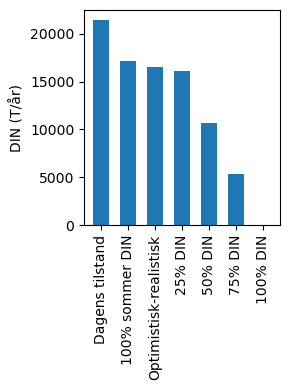

In [39]:
plt.figure(figsize=(3, 4))
ax = plt.gca()

# colors = ['grey', 'orange', 'red', 'green', 'green', 'green']
plt.bar(tot_of_df.index, tot_of_df['DIN'], width=0.6)#, color=colors)
plt.ylabel('DIN (T/år)')

# Rename x-axis labels
new_labels = ['Dagens tilstand', '100% sommer DIN', 'Optimistisk-realistisk', '25% DIN', '50% DIN', '75% DIN', '100% DIN']  # Provide your own labels
ax.set_xticklabels(new_labels)

# Rotate x-axis labels
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()

fpath = os.path.join(out_folder_figs, 'barchart_total-annual-din_whole-of800-domain.png')
plt.savefig(fpath)

plt.show()

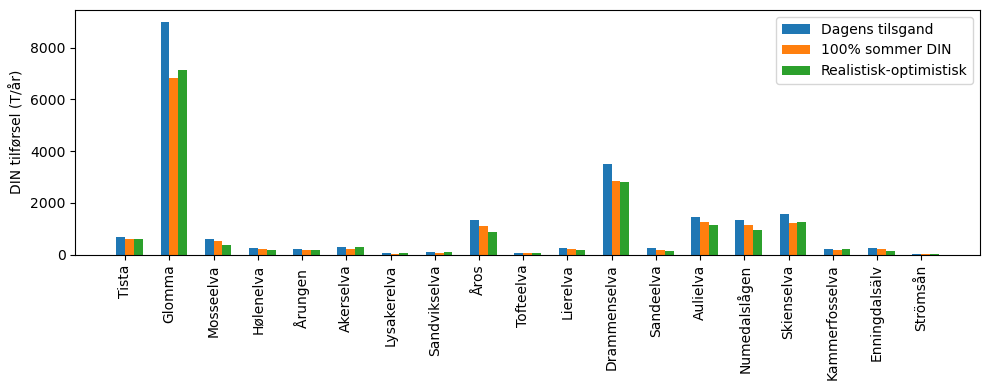

In [32]:
# Plot scenarios as bar chart, split by Vassdragsområder

translate_scenario_mapping = {'baseline': 'Dagens tilsgand',
                              'remove_summer_din': '100% sommer DIN',
                              'realistic': 'Realistisk-optimistisk'}

# Get the list of index values and reformat vassdragsområde to integers
df = tot_annual_av_dict['baseline'].copy()
locations = list(df.index.map(vass_num_to_name))

# Set the width of the bars
bar_width = 0.2

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10,4))

# For each scenario, plot a bar for each index value
for i, (scenario, df) in enumerate(tot_annual_av_dict.items()):
    new_label = translate_scenario_mapping.get(scenario, scenario)
    ax.bar(np.arange(len(df.index)) + i * bar_width, df['DIN'], bar_width, label=new_label)

# Set the x-ticks to be the index values
ax.set_xticks(np.arange(len(locations)) + bar_width / 2)
ax.set_xticklabels(locations)

# Tidy
ax.set_ylabel('DIN tilførsel (T/år)')
ax.tick_params(axis='x', rotation=90)
ax.legend()
plt.tight_layout()

fpath = os.path.join(out_folder_figs, 'barchart_total-annual-din_by-vassområde.png')
plt.savefig(fpath)

plt.show()

In [31]:
df.loc['002.', 'DIN'] / 1000

7.117095618799311

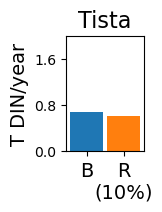

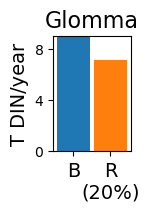

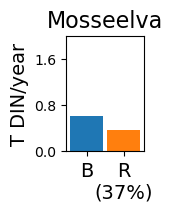

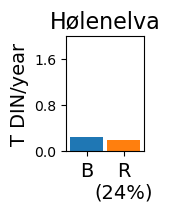

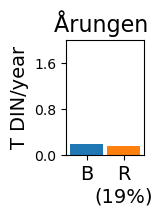

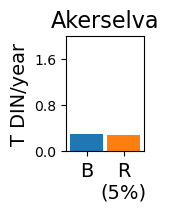

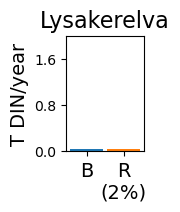

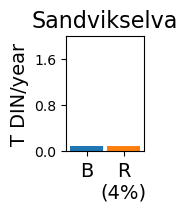

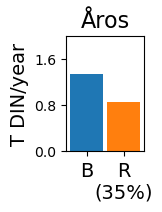

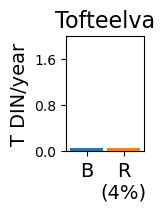

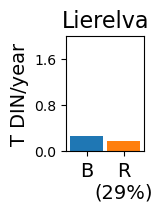

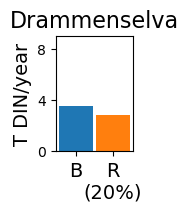

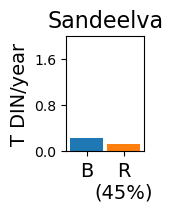

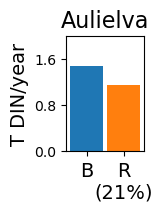

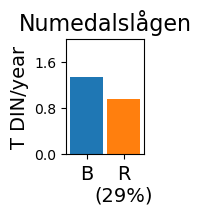

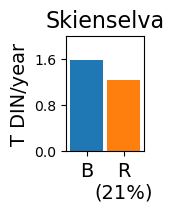

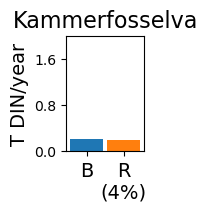

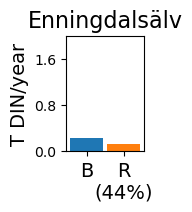

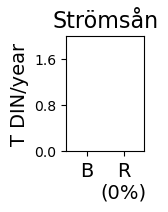

In [33]:
bar_width = 0.9
label_dict = {'baseline': 'B',
              'realistic': 'R'}

scen_li = ['baseline', 'realistic']
ymax_big = tot_annual_av_dict['baseline']['DIN'].max() / 1000
ymax_small = 2000.0 / 1000

for vassom in df.index:
    fig, ax = plt.subplots(figsize=(1, 1.5))

    # Set y-axis scale
    if vassom in ['002.', '012.']:
        ax.set_ylim(0, ymax_big)
    else:
        ax.set_ylim(0, ymax_small)

    for i, scenario in enumerate(scen_li):
        df = tot_annual_av_dict[scenario].copy()

        ax.bar(i, df.loc[vassom, 'DIN'] / 1000, bar_width, label=label_dict[scenario])

    # Set the x-ticks to be the scenarios
    pc_reduction = annual_av_res_df.loc[vassom, 'pc_DIN_reduction']
    t_din_removed = annual_av_res_df.loc[vassom, 'pc_DIN_reduction']
    ax.set_xticks(range(len(scen_li)))
    # ax.set_xticklabels([label_dict[scenario] for scenario in scen_li])
    ax.set_xticklabels([label_dict[scenario] + ('\n(' + str(pc_reduction) + '%)' if scenario == 'realistic' else '') for scenario in scen_li], size=14)

    # Simplify plot
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

    ax.set_ylabel('T DIN/year', size=14)
    ax.set_title(vass_num_to_name[vassom], size=16)

    fpath = os.path.join(out_folder_figs, 'vassom_barcharts', 'barchart_tot-ann-av-din_%s.png' % vass_num_to_name[vassom])
    plt.savefig(fpath, bbox_inches='tight')#, pad_inches=0.1)

plt.show()

## Monthly

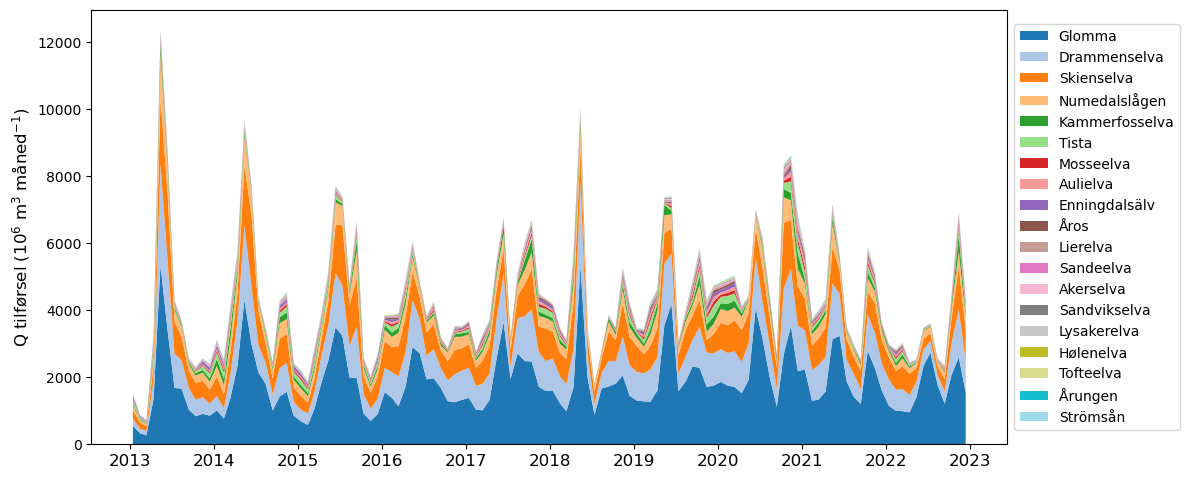

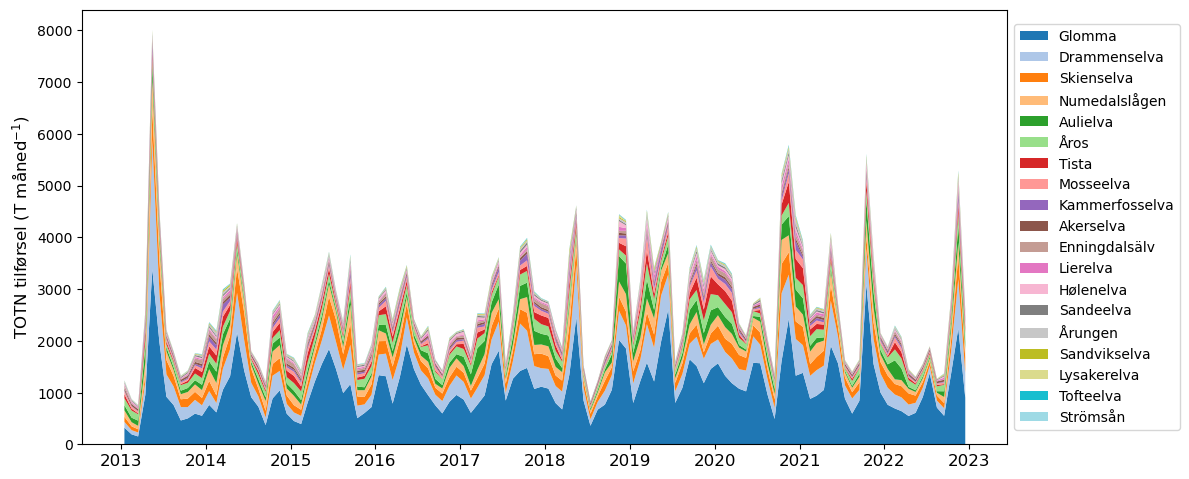

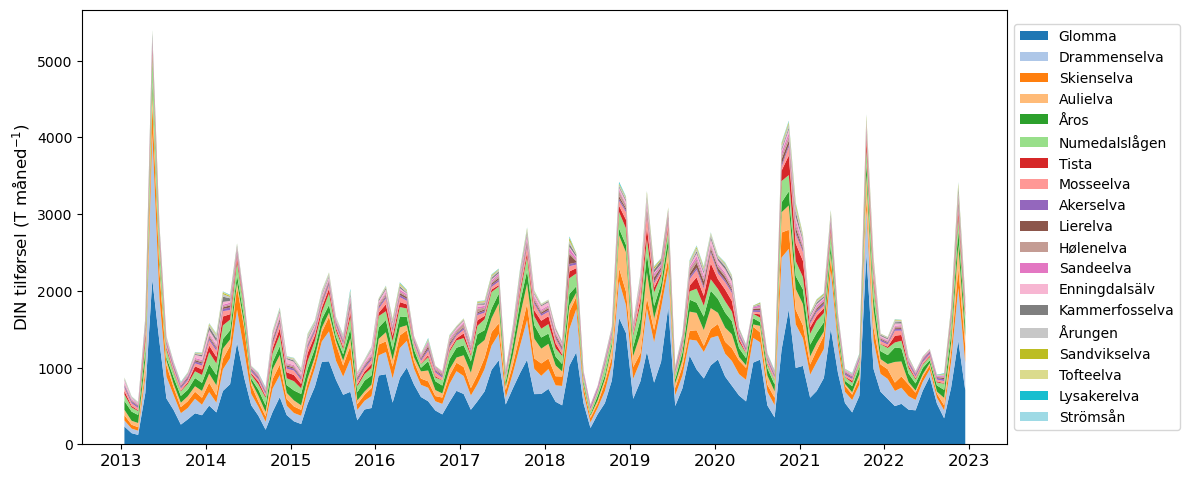

In [34]:
monthly_load_df = tot_month_dict['baseline'].copy()
monthly_load_df['Vassdragsområde'] = monthly_load_df['Vassom'].map(vass_num_to_name)

# Plot stacked line chart
monthflux_unit_dict = {
    "Q": "10$^6$ m$^3$ måned$^{-1}$",
    "TOTN": "T måned$^{-1}$",
    "DIN": "T måned$^{-1}$",
}

for var in ["Q", "TOTN", "DIN"]:

    pivot_df = monthly_load_df.pivot(index="date", columns="Vassdragsområde", values=var)

    total_contribution = (
        monthly_load_df.groupby("Vassdragsområde")[var].sum().sort_values(ascending=False)
    )

    # Order the columns of pivot_df according to total_contribution
    ordered_pivot_df = pivot_df[total_contribution.index]

    # Generate colors
    cmap = mpl.colormaps.get_cmap("tab20")  # 'tab20' is a colormap with 20 distinct colors
    colors = cmap(np.linspace(0, 1, len(ordered_pivot_df.columns)))

    # Plot
    plt.figure(figsize=(12, 5))
    plt.stackplot(
        ordered_pivot_df.index,
        ordered_pivot_df.T,
        labels=ordered_pivot_df.columns,
        colors=colors,
    )
    # xmin = mpl.dates.datestr2num('2016-01-01')
    # xmax = mpl.dates.datestr2num('2022-12-31')
    # plt.xlim([xmin, xmax])
    # plt.title("Monthly %s flux by vassdragsområde" % var)
    plt.ylabel(f"{var} tilførsel ({monthflux_unit_dict[var]})", fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    fpath = os.path.join(out_folder_figs, f'monthly_riv-and-isource_flux_{var}_{start_year}-{end_year}.png')
    plt.savefig(fpath)

    plt.show()

## Mean monthly mean fluxes

In [35]:
# Monthly mean load over all years
monthly_load_df['date'] = pd.to_datetime(monthly_load_df['date'])
monthly_load_df['month'] = monthly_load_df['date'].dt.month

monthly_mean_load_df = monthly_load_df.groupby(['Vassdragsområde', 'month']).mean(numeric_only=True).reset_index()
monthly_mean_load_df

,Vassdragsområde,month,Q,TOTN,DIN
0,Akerselva,1,12.702718,38.072366,24.266894
1,Akerselva,2,11.207784,38.330970,24.441607
2,Akerselva,3,13.880982,38.635239,24.511318
3,Akerselva,4,26.530774,43.550404,27.158221
4,Akerselva,5,26.828567,43.952597,27.336912
...,...,...,...,...,...
223,Årungen,8,3.849910,14.506031,10.436087
224,Årungen,9,4.559813,17.605667,12.519793
225,Årungen,10,7.763157,27.255968,18.224561
226,Årungen,11,9.584664,31.256201,21.158502


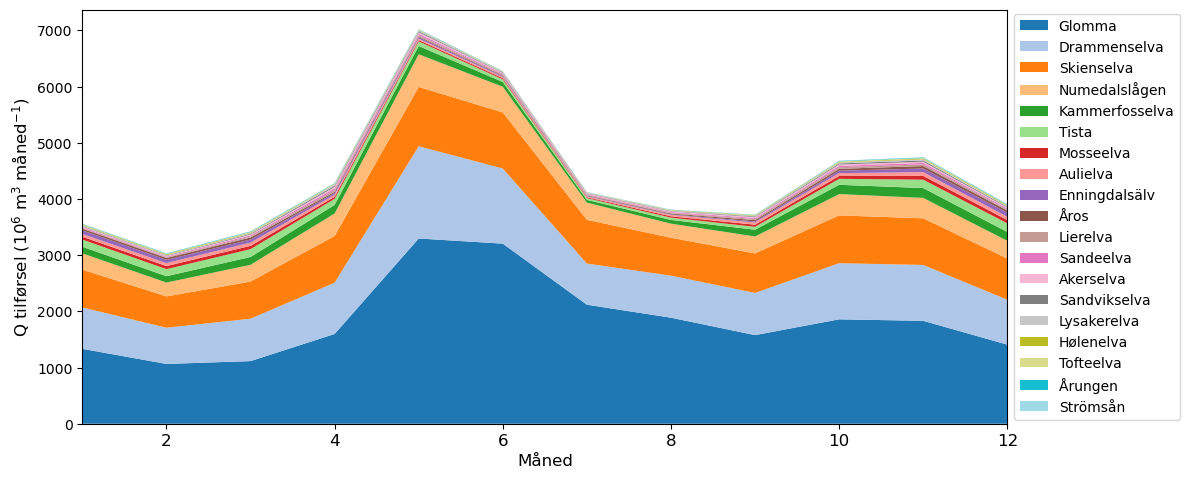

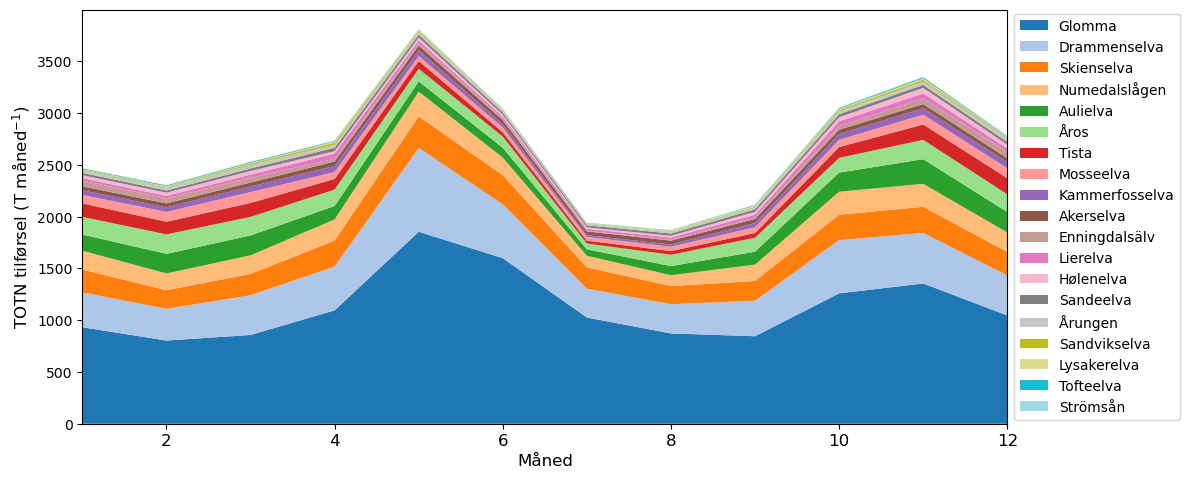

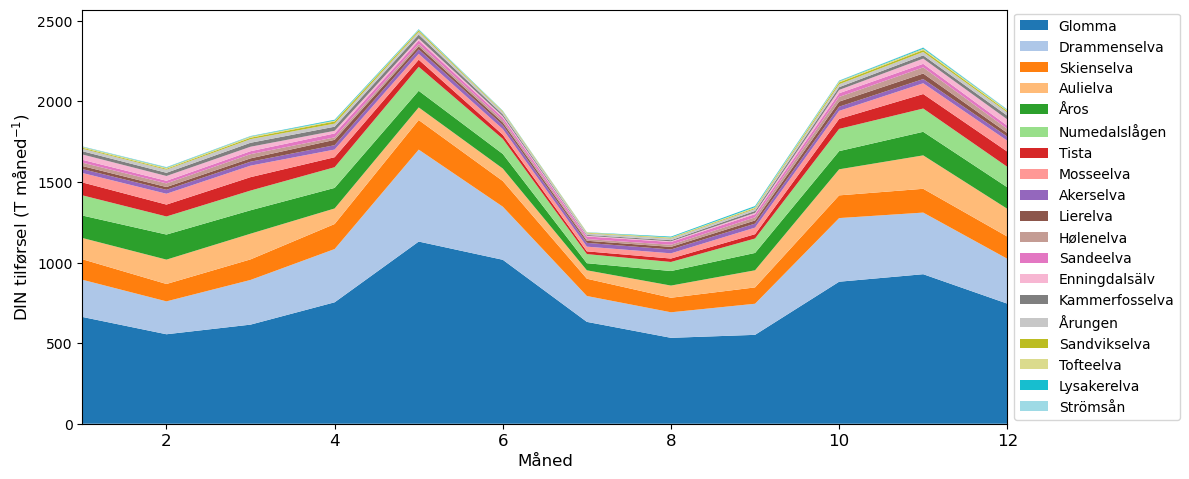

In [36]:
# Plot
for var in ["Q", "TOTN", "DIN"]:

    pivot_df = monthly_mean_load_df.pivot(index="month", columns="Vassdragsområde", values=var)

    total_contribution = (
        monthly_mean_load_df.groupby("Vassdragsområde")[var].sum().sort_values(ascending=False)
    )

    # Order the columns of pivot_df according to total_contribution
    ordered_pivot_df = pivot_df[total_contribution.index]

    # Generate colors
    cmap = mpl.colormaps.get_cmap("tab20")  # colormap with 20 colors
    colors = cmap(np.linspace(0, 1, len(ordered_pivot_df.columns)))

    # Plot
    plt.figure(figsize=(12, 5))
    plt.stackplot(
        ordered_pivot_df.index,
        ordered_pivot_df.T,
        labels=ordered_pivot_df.columns,
        colors=colors,
    )
    plt.xlim([1, 12])
    # plt.title("Monthly mean %s flux" % var)
    plt.ylabel(f"{var} tilførsel ({monthflux_unit_dict[var]})", fontsize=12)
    plt.xlabel("Måned", fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    fpath = os.path.join(out_folder_figs, f'monthly_mean_flux_{var}_{start_year}-{end_year}.png')
    plt.savefig(fpath)

    plt.show()

## Boxplots of daily values

**N.B. y-axis limit set to 6 below for clarity; this truncates TotN values:**
- Up to 17.5 in Hølenelva
- Up to 7.3 in Aulielva

In [37]:
conc_df = daily_conc_dict['baseline'].copy()
conc_df['river_name'] = conc_df['real_river'].map(river_meta_df['river_name'])
conc_df.head()

,real_river,date,Q,TOTN,DIN,river_name
0,4,2013-01-01 12:00:00,8.05,0.724679,0.237842,Strömsån
1,4,2013-01-02 12:00:00,3.42,0.728690,0.244108,Strömsån
2,4,2013-01-03 12:00:00,2.30,0.732297,0.249720,Strömsån
3,4,2013-01-04 12:00:00,1.88,0.735382,0.254493,Strömsån
4,4,2013-01-05 12:00:00,1.51,0.737911,0.258376,Strömsån


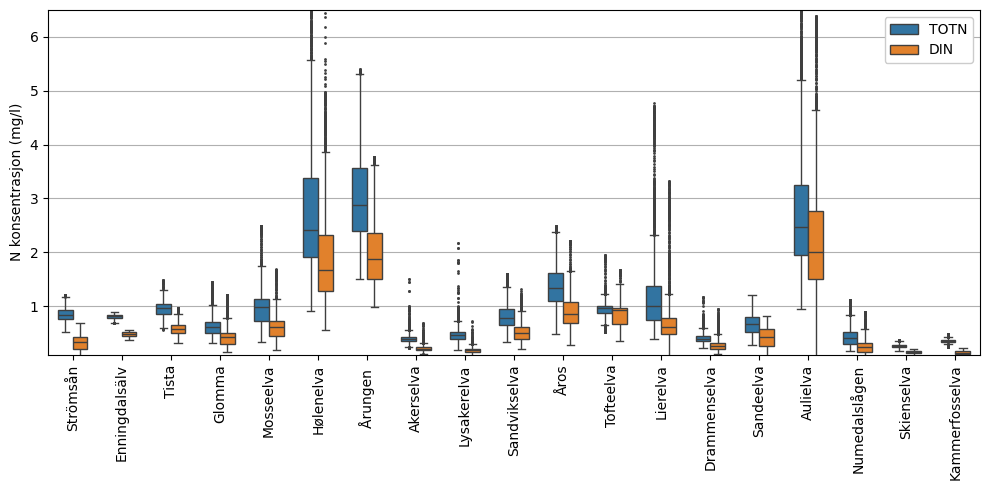

In [38]:
conc_df = daily_conc_dict['baseline'].copy()
conc_df['river_name'] = conc_df['real_river'].map(river_meta_df['river_name'])

# Melt dataFrame to have rivers, dates, variable (column1 or column2), and value
df_melted = conc_df[['TOTN', 'DIN', 'river_name', 'date']].melt(id_vars=['river_name', 'date'], var_name='variable', value_name='value')

# Create a boxplot
plt.figure(figsize=(10, 5))
box_plot = sns.boxplot(x='river_name', y='value', hue='variable', data=df_melted, fliersize=1, width=0.6, showfliers=True)

# Tidy up
box_plot.set_xlabel('')
box_plot.legend(title=None, framealpha=1)
plt.xticks(rotation=90)
plt.ylim(ymin=0.1, ymax=6.5)
# plt.yscale('log')
plt.grid(axis='y')
ax = plt.gca()  # Get the current Axes instance
ax.set_axisbelow(True)  # Set gridlines to be below other graph elements

plt.ylabel('N konsentrasjon (mg/l)')
# plt.title('Boxplot of Concentrations by River')

plt.tight_layout()
fpath = os.path.join(out_folder_figs, f'daily_conc_boxplots_{start_year}-{end_year}.png')
plt.savefig(fpath)

plt.show()